In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import importlib, import_ipynb
import data_clean_order_combined as data
import tensorflow as tf
from tensorflow.data import experimental
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings 
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

importing Jupyter notebook from data_clean_order_combined.ipynb
Length of original data set 209527
Number of examples with no short description:  19712
Number of examples with no headline:  6


c:\Users\natal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\natal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\natal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\natal\anacond

Stored 'test_df' (DataFrame)
Size of training data for combined:  167616
Size of testing data for combined:  41905
Stored 'rand_shuffled_text' (DataFrame)
Stored 'ordered_super_alpha_text' (DataFrame)
Stored 'ordered_class_alpha_text' (DataFrame)
Stored 'ordered_sem_clusters_desc_text' (DataFrame)
Stored 'ordered_sem_clusters_asc_text' (DataFrame)
Stored 'ordered_sem_clusters_shuffled_per_superclass_text' (DataFrame)


In [1]:
%store -r rand_shuffled_text
%store -r ordered_super_alpha_text
%store -r ordered_class_alpha_text
%store -r ordered_sem_clusters_desc_text
%store -r ordered_sem_clusters_asc_text
%store -r ordered_sem_clusters_shuffled_per_superclass_text
%store -r test_df

In [12]:
# Experimental data orderings on headlines TRAIN EXAMPLES
XB_train = rand_shuffled_text['combined']
X1_train = ordered_super_alpha_text['combined']
X2_train = ordered_class_alpha_text['combined']
X3_train = ordered_sem_clusters_desc_text['combined']
X4_train = ordered_sem_clusters_asc_text['combined']
X5_train = ordered_sem_clusters_shuffled_per_superclass_text['combined']

# Experimental data orderings on short_description #TODO

# TRAIN LABELS
YB_train = rand_shuffled_text['superclass']
Y1_train = ordered_super_alpha_text['superclass']
Y2_train = ordered_class_alpha_text['superclass']
Y3_train = ordered_sem_clusters_desc_text['superclass']
Y4_train = ordered_sem_clusters_asc_text['superclass']
Y5_train = ordered_sem_clusters_shuffled_per_superclass_text['superclass']

# TEST EXAMPLES
X_test = test_df['combined']
Y_test = test_df['superclass']

## Tokenization and Vectorization


### One-hot encoding and indexing of train and test data

In [13]:
# TEST DATA

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_test = encoder.fit_transform(Y_test)
print("shape of input data: ", X_test.shape)
print("shape of target variable: ", Y_test.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_test) # build the word index
# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test) # converts strinfs into integer lists
test_padseq = pad_sequences(test_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 150000000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 20 # max length of sequence 
Y_test = to_categorical(Y_test, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (41905,)
shape of target variable:  (41905,)
Length of word index: 44012


In [5]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

# BASELINE ORDER - RAND SHUFFLED

In [6]:
# BASELINE TRAIN DATA
X_train = XB_train
Y_train = YB_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 89122


### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer

In [7]:
model2B = Sequential()
model2B.add(Embedding(total_words, 100, input_length=maxlen))
model2B.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2B.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2B.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2B.add(Conv1D(72, 3, activation='relu'))
model2B.add(MaxPooling1D(2))
model2B.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2B.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model2B.add(Dropout(0.2))
model2B.add(Dense(9, activation='softmax'))
model2B.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           8912200   
                                                                 
 bidirectional (Bidirectiona  (None, 20, 128)          84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 18, 72)            27720     
                                                        

In [8]:
model2B.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history2B = model2B.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2
                   )

Epoch 1/15
1048/1048 [==============================] - 317s 279ms/step - loss: 1.7439 - accuracy: 0.5350 - val_loss: 1.2772 - val_accuracy: 0.6071
Epoch 2/15
1048/1048 [==============================] - 297s 284ms/step - loss: 1.0859 - accuracy: 0.6751 - val_loss: 1.0766 - val_accuracy: 0.6770
Epoch 3/15
1048/1048 [==============================] - 307s 293ms/step - loss: 0.9387 - accuracy: 0.7245 - val_loss: 1.0551 - val_accuracy: 0.6831
Epoch 4/15
1048/1048 [==============================] - 294s 281ms/step - loss: 0.8490 - accuracy: 0.7538 - val_loss: 1.1049 - val_accuracy: 0.6698
Epoch 5/15
1048/1048 [==============================] - 308s 294ms/step - loss: 0.7761 - accuracy: 0.7781 - val_loss: 1.0840 - val_accuracy: 0.6833
Epoch 6/15
1048/1048 [==============================] - 339s 323ms/step - loss: 0.7110 - accuracy: 0.7997 - val_loss: 1.1187 - val_accuracy: 0.6752
Epoch 7/15
1048/1048 [==============================] - 314s 300ms/step - loss: 0.6496 - accuracy: 0.8197 - val_

In [ ]:
# TEST DATA

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_test = encoder.fit_transform(Y_test)
print("shape of input data: ", X_test.shape)
print("shape of target variable: ", Y_test.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_test) # build the word index
# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test) # converts strinfs into integer lists
test_padseq = pad_sequences(test_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 150000000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 20 # max length of sequence 
Y_test = to_categorical(Y_test, num_classes=9)
print("Length of word index:", total_words)

Test loss and accuracy: 4.04546594619751 0.16461043059825897


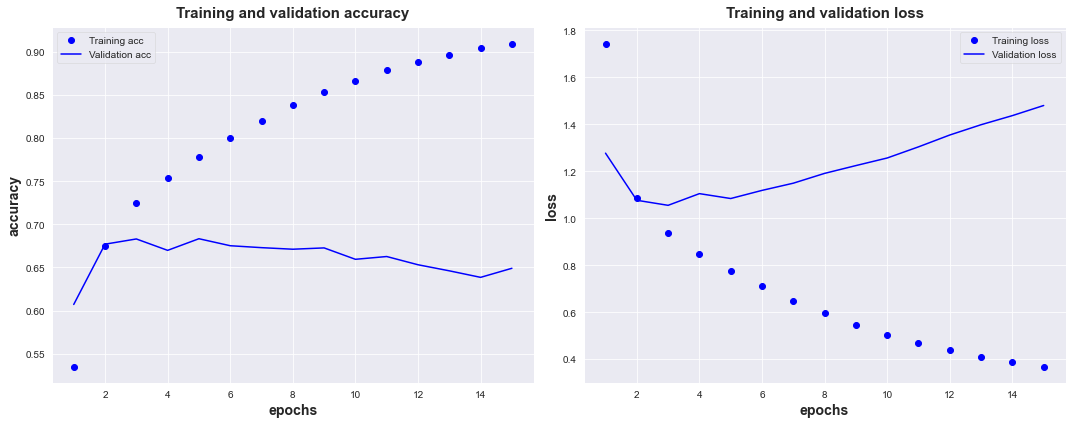

(41905,) (41905,)
[6 6 0 5 6] [6 6 3 6 6]
              precision    recall  f1-score   support

           0       0.08      0.10      0.09      3165
           1       0.04      0.04      0.04      1379
           2       0.21      0.24      0.23      8052
           3       0.11      0.09      0.10      4003
           4       0.15      0.17      0.16      5817
           5       0.16      0.12      0.14      4945
           6       0.27      0.23      0.25      9846
           7       0.06      0.07      0.07      2316
           8       0.07      0.08      0.07      2382

    accuracy                           0.16     41905
   macro avg       0.13      0.13      0.13     41905
weighted avg       0.17      0.16      0.17     41905



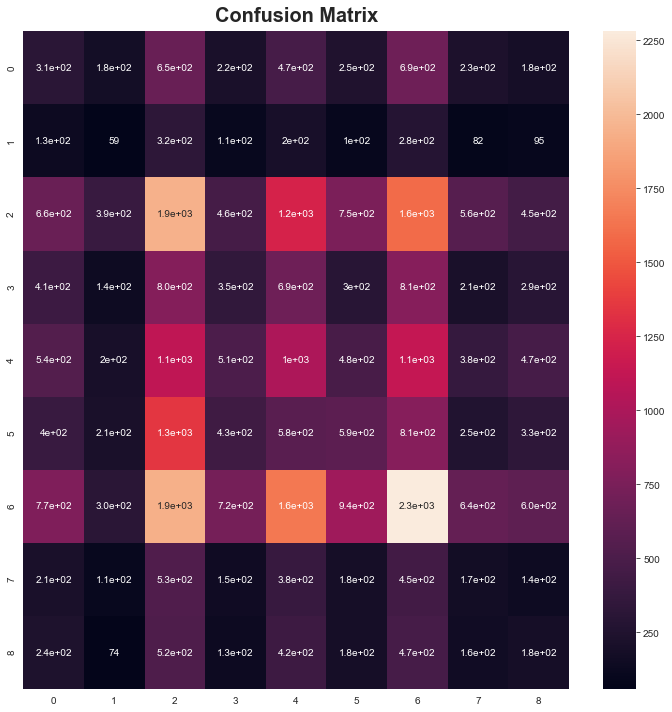

In [9]:
# evalute the model
test_loss, test_acc = model2B.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history2B)

Y_pred = model2B.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

# EXPERIMENT ORDER 1

In [6]:
# ORDER 1 TRAIN DATA
X_train = X1_train
Y_train = Y1_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 89122


### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer

In [7]:
model1 = Sequential()
model1.add(Embedding(total_words, 100, input_length=maxlen))
model1.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model1.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model1.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model1.add(Conv1D(72, 3, activation='relu'))
model1.add(MaxPooling1D(2))
model1.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model1.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model1.add(Dropout(0.2))
model1.add(Dense(9, activation='softmax'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           8912200   
                                                                 
 bidirectional (Bidirectiona  (None, 20, 128)          84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 18, 72)            27720     
                                                        

In [8]:
model1.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history1 = model1.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2,
                    shuffle=False
                   )

Epoch 1/15
1048/1048 [==============================] - 322s 275ms/step - loss: 0.5186 - accuracy: 0.9769 - val_loss: 8.8068 - val_accuracy: 0.4291
Epoch 2/15
1048/1048 [==============================] - 285s 272ms/step - loss: 0.1816 - accuracy: 0.9845 - val_loss: 10.6100 - val_accuracy: 0.4291
Epoch 3/15
1048/1048 [==============================] - 284s 271ms/step - loss: 0.1558 - accuracy: 0.9873 - val_loss: 11.3553 - val_accuracy: 0.4291
Epoch 4/15
1048/1048 [==============================] - 283s 270ms/step - loss: 0.1627 - accuracy: 0.9874 - val_loss: 11.8937 - val_accuracy: 0.4291
Epoch 5/15
1048/1048 [==============================] - 285s 272ms/step - loss: 0.1624 - accuracy: 0.9885 - val_loss: 12.2979 - val_accuracy: 0.4291
Epoch 6/15
1048/1048 [==============================] - 285s 272ms/step - loss: 0.1618 - accuracy: 0.9883 - val_loss: 11.9286 - val_accuracy: 0.4291
Epoch 7/15
1048/1048 [==============================] - 284s 271ms/step - loss: 0.1647 - accuracy: 0.9877 -

Test loss and accuracy: 15.726014137268066 0.23496003448963165


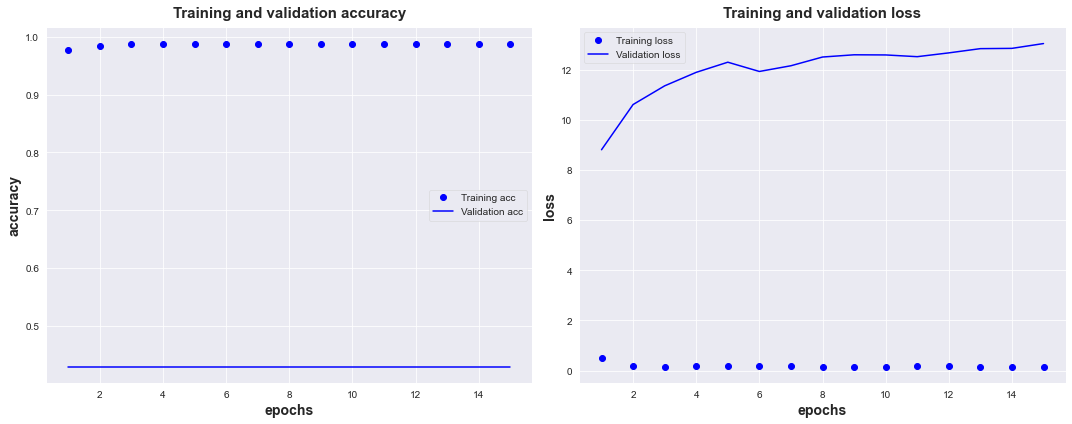

(41905,) (41905,)
[6 6 0 5 6] [6 6 6 6 6]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3165
           1       0.00      0.00      0.00      1379
           2       0.00      0.00      0.00      8052
           3       0.00      0.00      0.00      4003
           4       0.00      0.00      0.00      5817
           5       0.00      0.00      0.00      4945
           6       0.23      1.00      0.38      9846
           7       0.00      0.00      0.00      2316
           8       0.00      0.00      0.00      2382

    accuracy                           0.23     41905
   macro avg       0.03      0.11      0.04     41905
weighted avg       0.06      0.23      0.09     41905



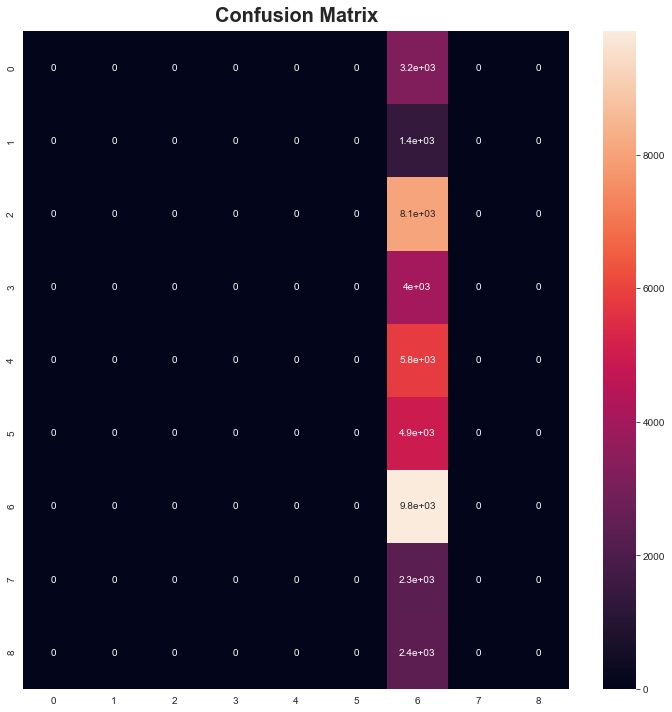

In [14]:
# evalute the model
test_loss, test_acc = model1.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history1)

Y_pred = model1.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

# EXPERIMENT ORDER 2

In [15]:
# ORDER 2 TRAIN DATA
X_train = X2_train
Y_train = Y2_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 89122


### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer

In [16]:
model2 = Sequential()
model2.add(Embedding(total_words, 100, input_length=maxlen))
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Conv1D(72, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model2.add(Dropout(0.2))
model2.add(Dense(9, activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           8912200   
                                                                 
 bidirectional_3 (Bidirectio  (None, 20, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 20, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 72)            27720     
                                                      

In [17]:
model2.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history2 = model2.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2,
                    shuffle=False
                   )

Epoch 1/15
1048/1048 [==============================] - 336s 289ms/step - loss: 0.7091 - accuracy: 0.9370 - val_loss: 7.4564 - val_accuracy: 0.2299
Epoch 2/15
1048/1048 [==============================] - 308s 294ms/step - loss: 0.3742 - accuracy: 0.9453 - val_loss: 7.8067 - val_accuracy: 0.2299
Epoch 3/15
1048/1048 [==============================] - 307s 292ms/step - loss: 0.3538 - accuracy: 0.9495 - val_loss: 8.0948 - val_accuracy: 0.2299
Epoch 4/15
1048/1048 [==============================] - 305s 291ms/step - loss: 0.3449 - accuracy: 0.9519 - val_loss: 8.9453 - val_accuracy: 0.2299
Epoch 5/15
1048/1048 [==============================] - 306s 292ms/step - loss: 0.3305 - accuracy: 0.9552 - val_loss: 9.1716 - val_accuracy: 0.2299
Epoch 6/15
1048/1048 [==============================] - 306s 292ms/step - loss: 0.3302 - accuracy: 0.9578 - val_loss: 8.5826 - val_accuracy: 0.2299
Epoch 7/15
1048/1048 [==============================] - 305s 291ms/step - loss: 0.3261 - accuracy: 0.9575 - val_

In [18]:
# TEST DATA

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_test = encoder.fit_transform(Y_test)
print("shape of input data: ", X_test.shape)
print("shape of target variable: ", Y_test.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_test) # build the word index
# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test) # converts strinfs into integer lists
test_padseq = pad_sequences(test_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 150000000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 20 # max length of sequence 
Y_test = to_categorical(Y_test, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (41905,)
shape of target variable:  (41905,)
Length of word index: 44012


Test loss and accuracy: 8.8084135055542 0.19248299300670624


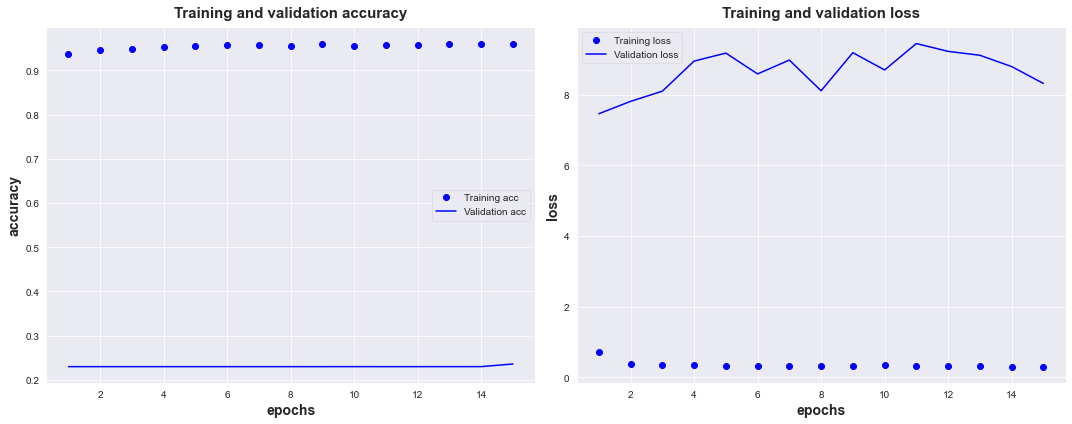

(41905,) (41905,)
[6 6 0 5 6] [2 2 2 2 2]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3165
           1       0.00      0.00      0.00      1379
           2       0.19      1.00      0.32      8052
           3       0.00      0.00      0.00      4003
           4       0.00      0.00      0.00      5817
           5       0.00      0.00      0.00      4945
           6       0.26      0.00      0.01      9846
           7       0.00      0.00      0.00      2316
           8       0.00      0.00      0.00      2382

    accuracy                           0.19     41905
   macro avg       0.05      0.11      0.04     41905
weighted avg       0.10      0.19      0.06     41905



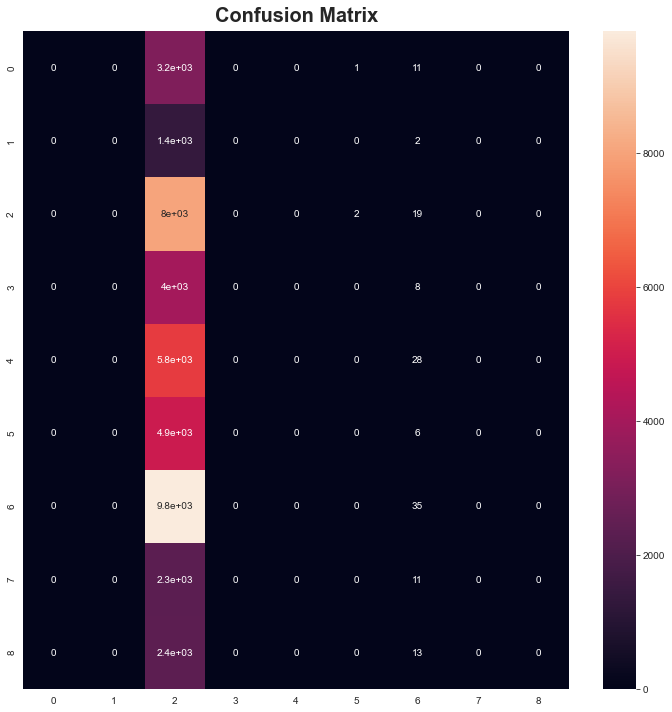

In [19]:
# evalute the model
test_loss, test_acc = model2.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history2)

Y_pred = model2.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

Stopped: 

Best training accuracy:

Best validation accuracy: 

Test accuracy:

Training time:

# EXPERIMENT ORDER 3

In [20]:
# ORDER 3 TRAIN DATA
X_train = X3_train
Y_train = Y3_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 89122


### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer

In [21]:
model3 = Sequential()
model3.add(Embedding(total_words, 100, input_length=maxlen))
model3.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model3.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model3.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model3.add(Conv1D(72, 3, activation='relu'))
model3.add(MaxPooling1D(2))
model3.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model3.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model3.add(Dropout(0.2))
model3.add(Dense(9, activation='softmax'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 100)           8912200   
                                                                 
 bidirectional_6 (Bidirectio  (None, 20, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 20, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 18, 72)            27720     
                                                      

In [22]:
model3.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history3 = model3.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2,
                    shuffle=False
                   )

Epoch 1/15
1048/1048 [==============================] - 323s 275ms/step - loss: 0.5361 - accuracy: 0.9773 - val_loss: 4.8576 - val_accuracy: 0.2655
Epoch 2/15
1048/1048 [==============================] - 283s 270ms/step - loss: 0.1692 - accuracy: 0.9890 - val_loss: 5.8341 - val_accuracy: 0.2655
Epoch 3/15
1048/1048 [==============================] - 284s 271ms/step - loss: 0.1433 - accuracy: 0.9891 - val_loss: 6.0618 - val_accuracy: 0.2655
Epoch 4/15
1048/1048 [==============================] - 282s 269ms/step - loss: 0.1520 - accuracy: 0.9893 - val_loss: 6.5555 - val_accuracy: 0.2655
Epoch 5/15
1048/1048 [==============================] - 285s 272ms/step - loss: 0.1429 - accuracy: 0.9902 - val_loss: 6.7034 - val_accuracy: 0.2655
Epoch 6/15
1048/1048 [==============================] - 282s 269ms/step - loss: 0.1514 - accuracy: 0.9896 - val_loss: 7.0616 - val_accuracy: 0.2655
Epoch 7/15
1048/1048 [==============================] - 305s 291ms/step - loss: 0.1492 - accuracy: 0.9904 - val_

In [23]:
# TEST DATA

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_test = encoder.fit_transform(Y_test)
print("shape of input data: ", X_test.shape)
print("shape of target variable: ", Y_test.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_test) # build the word index
# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test) # converts strinfs into integer lists
test_padseq = pad_sequences(test_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 150000000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 20 # max length of sequence 
Y_test = to_categorical(Y_test, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (41905,)
shape of target variable:  (41905,)
Length of word index: 44012


Test loss and accuracy: 12.628576278686523 0.07552798092365265


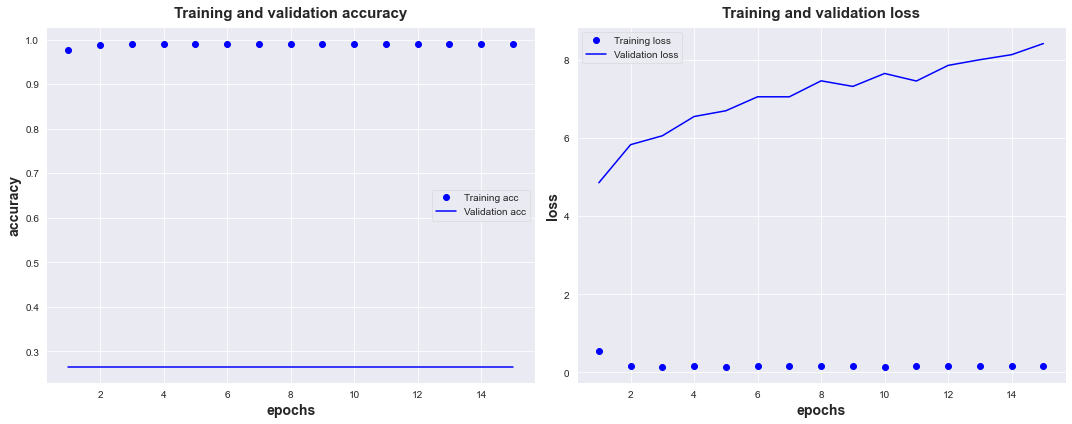

(41905,) (41905,)
[6 6 0 5 6] [0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.08      1.00      0.14      3165
           1       0.00      0.00      0.00      1379
           2       0.00      0.00      0.00      8052
           3       0.00      0.00      0.00      4003
           4       0.00      0.00      0.00      5817
           5       0.00      0.00      0.00      4945
           6       0.00      0.00      0.00      9846
           7       0.00      0.00      0.00      2316
           8       0.00      0.00      0.00      2382

    accuracy                           0.08     41905
   macro avg       0.01      0.11      0.02     41905
weighted avg       0.01      0.08      0.01     41905



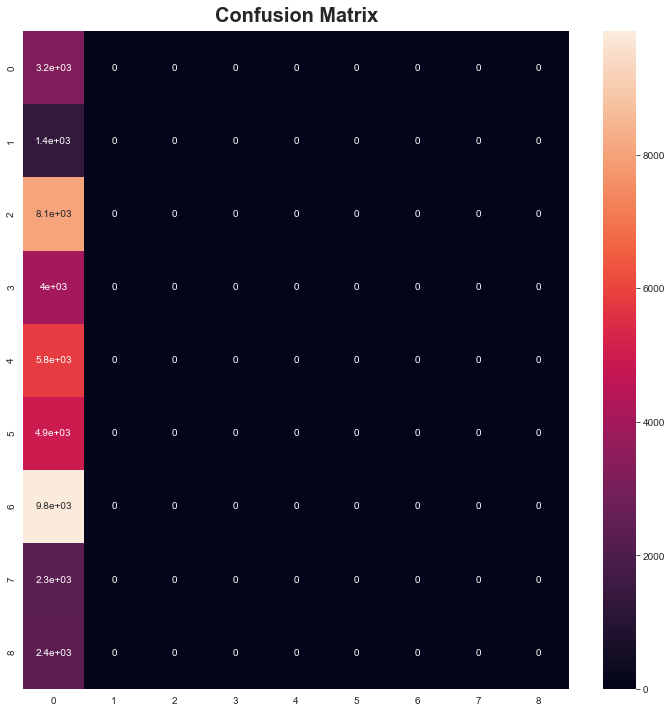

In [24]:
# evalute the model
test_loss, test_acc = model3.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history3)

Y_pred = model3.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

Stopped: 

Best training accuracy:

Best validation accuracy: 

Test accuracy:

Training time:

# EXPERIMENT ORDER 4

In [25]:
# ORDER 4 TRAIN DATA
X_train = X4_train
Y_train = Y4_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 89122


### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer


In [26]:
model4 = Sequential()
model4.add(Embedding(total_words, 100, input_length=maxlen))
model4.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model4.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model4.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model4.add(Conv1D(72, 3, activation='relu'))
model4.add(MaxPooling1D(2))
model4.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model4.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model4.add(Dropout(0.2))
model4.add(Dense(9, activation='softmax'))
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 100)           8912200   
                                                                 
 bidirectional_9 (Bidirectio  (None, 20, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 20, 128)          98816     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 20, 128)          24704     
 onal)                                                           
                                                                 
 conv1d_3 (Conv1D)           (None, 18, 72)            27720     
                                                      

In [27]:
model4.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history4 = model4.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2,
                    shuffle=False
                   )

Epoch 1/15
1048/1048 [==============================] - 343s 293ms/step - loss: 0.5599 - accuracy: 0.9702 - val_loss: 0.0652 - val_accuracy: 1.0000
Epoch 2/15
1048/1048 [==============================] - 305s 291ms/step - loss: 0.1930 - accuracy: 0.9823 - val_loss: 0.0623 - val_accuracy: 1.0000
Epoch 3/15
1048/1048 [==============================] - 290s 277ms/step - loss: 0.1688 - accuracy: 0.9846 - val_loss: 0.0619 - val_accuracy: 1.0000
Epoch 4/15
1048/1048 [==============================] - 280s 267ms/step - loss: 0.1712 - accuracy: 0.9839 - val_loss: 0.0612 - val_accuracy: 1.0000
Epoch 5/15
1048/1048 [==============================] - 277s 265ms/step - loss: 0.1622 - accuracy: 0.9843 - val_loss: 0.0607 - val_accuracy: 1.0000
Epoch 6/15
1048/1048 [==============================] - 278s 266ms/step - loss: 0.1653 - accuracy: 0.9840 - val_loss: 0.0609 - val_accuracy: 1.0000
Epoch 7/15
1048/1048 [==============================] - 278s 265ms/step - loss: 0.1717 - accuracy: 0.9834 - val_

In [28]:
# TEST DATA

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_test = encoder.fit_transform(Y_test)
print("shape of input data: ", X_test.shape)
print("shape of target variable: ", Y_test.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_test) # build the word index
# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test) # converts strinfs into integer lists
test_padseq = pad_sequences(test_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 150000000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 20 # max length of sequence 
Y_test = to_categorical(Y_test, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (41905,)
shape of target variable:  (41905,)
Length of word index: 44012


Test loss and accuracy: 9.533671379089355 0.23496003448963165


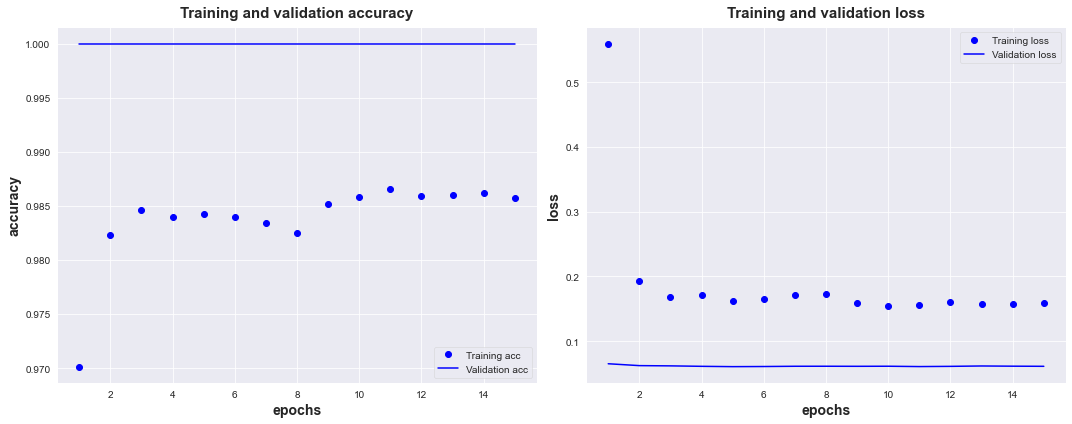

(41905,) (41905,)
[6 6 0 5 6] [6 6 6 6 6]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3165
           1       0.00      0.00      0.00      1379
           2       0.00      0.00      0.00      8052
           3       0.00      0.00      0.00      4003
           4       0.00      0.00      0.00      5817
           5       0.00      0.00      0.00      4945
           6       0.23      1.00      0.38      9846
           7       0.00      0.00      0.00      2316
           8       0.00      0.00      0.00      2382

    accuracy                           0.23     41905
   macro avg       0.03      0.11      0.04     41905
weighted avg       0.06      0.23      0.09     41905



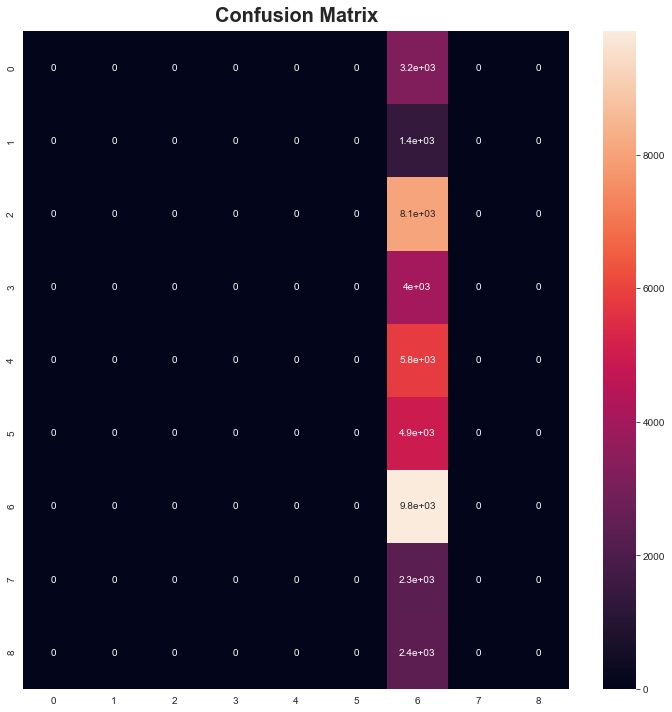

In [29]:
# evalute the model
test_loss, test_acc = model4.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history4)

Y_pred = model4.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

Stopped: 

Best training accuracy:

Best validation accuracy: 

Test accuracy:

Training time:

# EXPERIMENT ORDER 5

In [30]:
# ORDER 5 TRAIN DATA
X_train = X5_train
Y_train = Y5_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 89122


### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer


In [31]:
model5 = Sequential()
model5.add(Embedding(total_words, 100, input_length=maxlen))
model5.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model5.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model5.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model5.add(Conv1D(72, 3, activation='relu'))
model5.add(MaxPooling1D(2))
model5.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model5.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model5.add(Dropout(0.2))
model5.add(Dense(9, activation='softmax'))
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 100)           8912200   
                                                                 
 bidirectional_12 (Bidirecti  (None, 20, 128)          84480     
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 20, 128)          98816     
 onal)                                                           
                                                                 
 bidirectional_14 (Bidirecti  (None, 20, 128)          24704     
 onal)                                                           
                                                                 
 conv1d_4 (Conv1D)           (None, 18, 72)            27720     
                                                      

In [32]:
model5.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history5 = model5.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2,
                    shuffle=False
                   )

Epoch 1/15
1048/1048 [==============================] - 307s 259ms/step - loss: 0.5365 - accuracy: 0.9792 - val_loss: 5.2092 - val_accuracy: 0.2655
Epoch 2/15
1048/1048 [==============================] - 271s 258ms/step - loss: 0.1670 - accuracy: 0.9882 - val_loss: 5.7777 - val_accuracy: 0.2655
Epoch 3/15
1048/1048 [==============================] - 269s 257ms/step - loss: 0.1532 - accuracy: 0.9894 - val_loss: 6.0849 - val_accuracy: 0.2655
Epoch 4/15
1048/1048 [==============================] - 270s 258ms/step - loss: 0.1632 - accuracy: 0.9878 - val_loss: 6.2942 - val_accuracy: 0.2655
Epoch 5/15
1048/1048 [==============================] - 270s 257ms/step - loss: 0.1603 - accuracy: 0.9886 - val_loss: 6.5058 - val_accuracy: 0.2655
Epoch 6/15
1048/1048 [==============================] - 269s 257ms/step - loss: 0.1588 - accuracy: 0.9892 - val_loss: 6.9187 - val_accuracy: 0.2655
Epoch 7/15
1048/1048 [==============================] - 269s 257ms/step - loss: 0.1552 - accuracy: 0.9892 - val_

In [33]:
# TEST DATA

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_test = encoder.fit_transform(Y_test)
print("shape of input data: ", X_test.shape)
print("shape of target variable: ", Y_test.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_test) # build the word index
# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test) # converts strinfs into integer lists
test_padseq = pad_sequences(test_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 150000000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 20 # max length of sequence 
Y_test = to_categorical(Y_test, num_classes=9)
print("Length of word index:", total_words)

shape of input data:  (41905,)
shape of target variable:  (41905,)
Length of word index: 44012


Test loss and accuracy: 10.587128639221191 0.07552798092365265


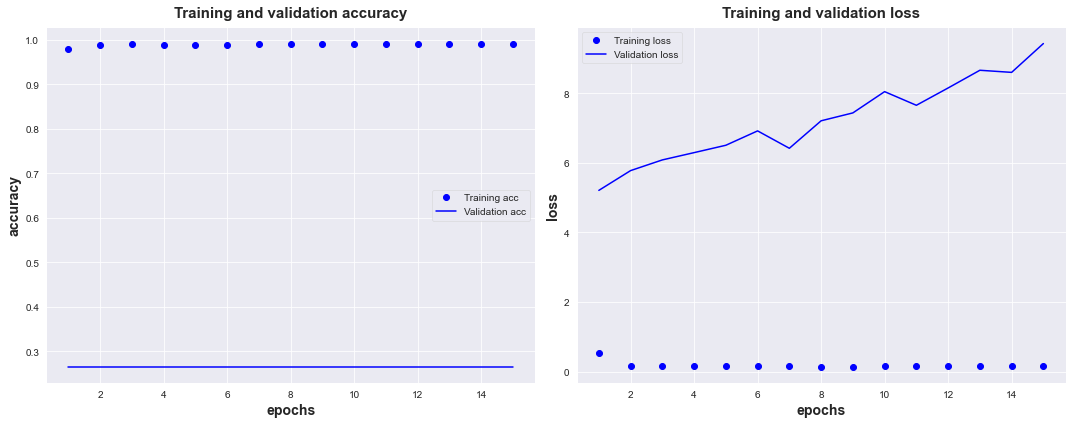

(41905,) (41905,)
[6 6 0 5 6] [0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.08      1.00      0.14      3165
           1       0.00      0.00      0.00      1379
           2       0.00      0.00      0.00      8052
           3       0.00      0.00      0.00      4003
           4       0.00      0.00      0.00      5817
           5       0.00      0.00      0.00      4945
           6       0.00      0.00      0.00      9846
           7       0.00      0.00      0.00      2316
           8       0.00      0.00      0.00      2382

    accuracy                           0.08     41905
   macro avg       0.01      0.11      0.02     41905
weighted avg       0.01      0.08      0.01     41905



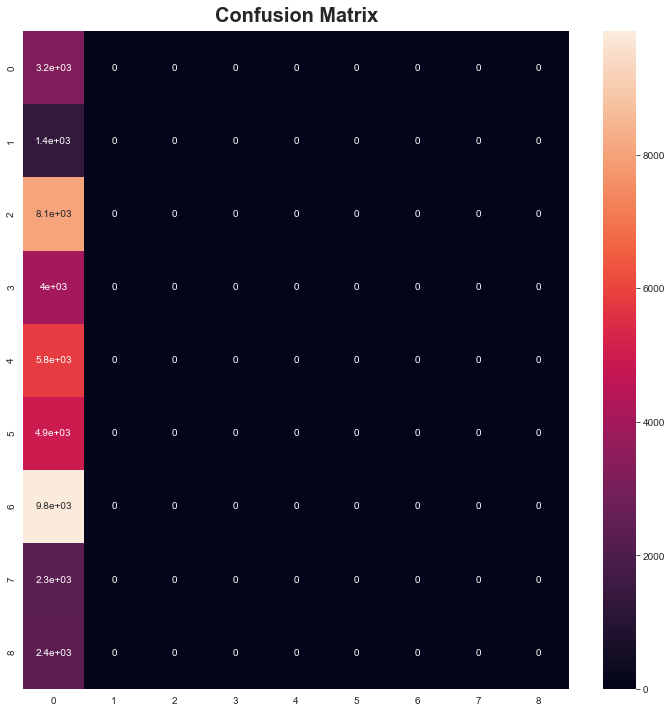

In [34]:
# evalute the model
test_loss, test_acc = model5.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history5)

Y_pred = model5.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);